In [1]:
import os
os.environ["CONDA_PREFIX"] = "/opt/conda" if os.path.exists("/opt/conda") else '/usr/local'
!pip install -U -q uv

In [2]:
!uv pip install modAL-python torchvision torcheval mlxtend torchsummary scikit-learn-intelex

Resolved 44 packages in 1.49s
Downloaded 15 packages in 1.19s
Installed 15 packages in 55ms
 - contourpy==1.2.0
 - contourpy==1.2.1 (from file:///home/conda/feedstock_root/build_artifacts/contourpy_1712429905637/work)
 + contourpy==1.2.0
 - fonttools==4.47.0
 - fonttools==4.51.0 (from file:///home/conda/feedstock_root/build_artifacts/fonttools_1712344558731/work)
 + fonttools==4.47.0
 - fsspec==2024.2.0
 - fsspec==2024.3.1 (from file:///home/conda/feedstock_root/build_artifacts/fsspec_1710808267764/work)
 + fsspec==2024.2.0
 - markupsafe==2.1.5
 - markupsafe==2.1.3 (from file:///home/conda/feedstock_root/build_artifacts/markupsafe_1695367434228/work)
 + markupsafe==2.1.5
 - matplotlib==3.7.5
 - matplotlib==3.8.4 (from file:///home/conda/feedstock_root/build_artifacts/matplotlib-suite_1712605966339/work)
 + matplotlib==3.7.5
 + modal-python==0.4.2.1
 - pandas==2.1.4
 - pandas==2.2.2
 + pandas==2.2.2
 - pillow==9.5.0
 - pillow==10.3.0 (from file:///home/conda/feedstock_root/build_artifac

# Imports


In [3]:
import random
import warnings
from pathlib import Path
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from mlxtend.plotting import plot_confusion_matrix
from modAL.disagreement import vote_entropy_sampling
from modAL.models import ActiveLearner, Committee
from modAL.uncertainty import entropy_sampling, margin_sampling, uncertainty_sampling
from sklearnex import patch_sklearn
from skorch import NeuralNetClassifier
from torch import nn
from torcheval.metrics.functional import (
    multiclass_accuracy,
    multiclass_confusion_matrix,
    multiclass_f1_score,
    multiclass_precision,
    multiclass_recall,
)
from torchsummary import summary
from torchvision import datasets, models
from torchvision.transforms import ToTensor
from tqdm.auto import tqdm

if not os.path.exists("reports_FashionMNIST"): os.mkdir("reports_FashionMNIST")
patch_sklearn()
print("torch", torch.__version__)
print("torchvision", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU List:", torch.cuda.device_count())
print("Current Device:", torch.cuda.current_device())
warnings.filterwarnings("ignore")

torch 2.1.2
torchvision 0.16.2
CUDA available: True
GPU List: 1
Current Device: 0


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Data

## FashionMNIST


In [4]:
FashionMNIST_train_data = datasets.FashionMNIST(
    root="data_FashionMNIST",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)
FashionMNIST_test_data = datasets.FashionMNIST(
    root="data_FashionMNIST",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)

x_train, y_train = FashionMNIST_train_data.data, np.array(FashionMNIST_train_data.targets)
x_test, y_test = FashionMNIST_test_data.data, np.array(FashionMNIST_test_data.targets)

100%|██████████| 26421880/26421880 [00:04<00:00, 6500743.39it/s] 


Extracting data_FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to data_FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 50999.43it/s]


Extracting data_FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data_FashionMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 1886943.38it/s]


Extracting data_FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data_FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11665195.57it/s]

Extracting data_FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data_FashionMNIST/FashionMNIST/raw



In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [6]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([60000, 28, 28]), (60000,), torch.Size([10000, 28, 28]), (10000,))

In [7]:
x_train = x_train.unsqueeze(1).repeat(1, 3, 1, 1)
x_test = x_test.unsqueeze(1).repeat(1, 3, 1, 1)

x_train = x_train.numpy()
x_test = x_test.numpy()

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

In [8]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 3, 28, 28), (60000,), (10000, 3, 28, 28), (10000,))

In [9]:
FashionMNIST_class_names = FashionMNIST_train_data.classes
FashionMNIST_class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [10]:
num_classes = len(FashionMNIST_class_names)
num_classes

10

In [11]:
class_to_idx_cif = FashionMNIST_train_data.class_to_idx
class_to_idx_cif

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

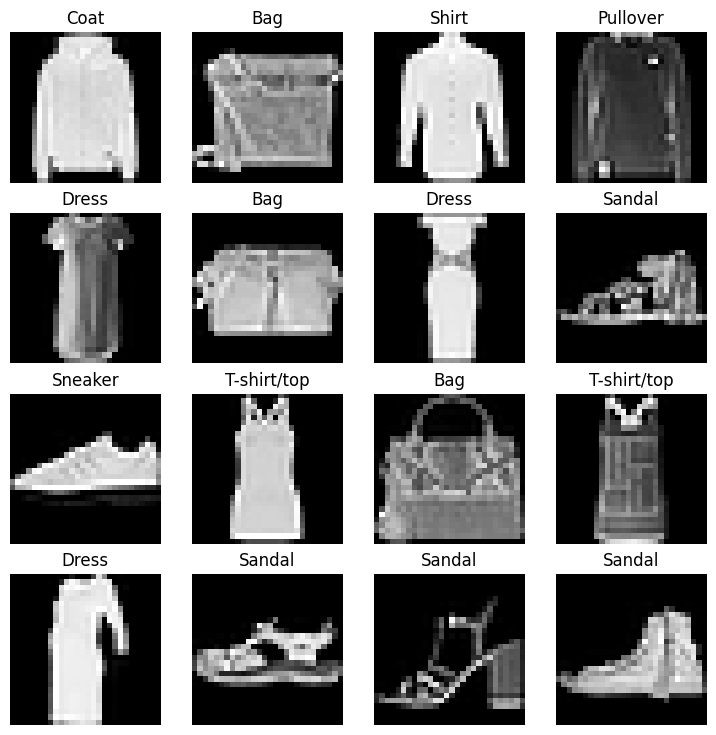

In [12]:
plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, rows * cols + 1):
    random_index = torch.randint(1, len(FashionMNIST_train_data), size=[1]).item()
    plt.subplot(rows, cols, i)
    image, label = FashionMNIST_train_data[random_index]
    image = image.permute(1, 2, 0).numpy()
    plt.imshow(image, cmap="gray")
    plt.title(FashionMNIST_class_names[label])
    plt.axis(False)

plt.savefig("reports_FashionMNIST/FashionMNIST_images_with_label.png")
plt.show()

## Unlabelling The Dataset


In [13]:
percentage_without_labels = 0.8

num_samples_without_labels = int(len(FashionMNIST_train_data) * percentage_without_labels)
num_samples_with_labels = len(FashionMNIST_train_data) - num_samples_without_labels

indices_without_labels = np.random.choice(range(len(FashionMNIST_train_data)), size=num_samples_without_labels, replace=False)
indices_with_labels = np.array([i for i in range(len(FashionMNIST_train_data)) if i not in indices_without_labels])

x_initial = x_train[indices_with_labels]
y_initial = y_train[indices_with_labels]

x_pool = np.delete(x_train, indices_with_labels, axis=0)
y_pool = np.delete(y_train, indices_with_labels, axis=0)

In [14]:
x_initial.shape, y_initial.shape, x_pool.shape, y_pool.shape

((12000, 3, 28, 28), (12000,), (48000, 3, 28, 28), (48000,))

In [15]:
len(FashionMNIST_train_data)

60000

In [16]:
FashionMNIST_train_data[1][1]

0

## Creating the DataLoaders


In [17]:
def numpy_to_dataloader(x, y, batch_size=32):
    dataset = torch.utils.data.TensorDataset(torch.tensor(x, dtype=torch.float32), torch.tensor(y))
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [18]:
BATCH_SIZE_CIF = 32

In [19]:
FashionMNIST_train_data_loader = numpy_to_dataloader(x_initial, y_initial, BATCH_SIZE_CIF)
FashionMNIST_test_data_loader = numpy_to_dataloader(x_test, y_test, BATCH_SIZE_CIF)

In [20]:
FashionMNIST_train_data_loader, FashionMNIST_test_data_loader

(<torch.utils.data.dataloader.DataLoader at 0x7a079c953ac0>,
 <torch.utils.data.dataloader.DataLoader at 0x7a06a97b7eb0>)

In [21]:
print(f"Length of Training Data loader: {len(FashionMNIST_train_data_loader)}, Batches of {FashionMNIST_train_data_loader.batch_size}")
print(f"Length of Testing Data loader: {len(FashionMNIST_test_data_loader)}, Batches of {FashionMNIST_test_data_loader.batch_size}")

Length of Training Data loader: 375, Batches of 32
Length of Testing Data loader: 313, Batches of 32


# Raw Model

## Importing and Using ResNet 50 Architecture


In [22]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [23]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
next(model.parameters()).device

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 164MB/s]


device(type='cpu')

In [24]:
model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

## Printing the Architecture and Number of Training Parameters in each Layer


In [25]:
summary(model, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]           4,096
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]          16,384
      BatchNorm2d-12            [-1, 256, 7, 7]             512
           Conv2d-13            [-1, 256, 7, 7]          16,384
      BatchNorm2d-14            [-1, 25

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [27]:
def display_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on device {device}: {total_time:.3f} seconds")

In [28]:
start = timer()
end = timer()
display_train_time(start, end, device="cpu")

Train time on device cpu: 0.000 seconds


In [29]:
def train_step(
    model: nn.Module,
    data_loader: torch.utils.data.dataloader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device = device,
):
    training_loss = []
    training_acc = []
    model.train()

    for batch, (x, y) in enumerate(data_loader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        training_loss.append(loss)
        training_acc.append(multiclass_accuracy(y_pred.argmax(dim=1), y, num_classes=10))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    training_loss = torch.tensor(training_loss).mean()
    training_acc = torch.tensor(training_acc).mean()
    print(f"Training -> Loss: {training_loss:.3f} | Accuracy: {training_acc:.3f}")
    return training_acc, training_loss

In [30]:
def test_step(
    model: nn.Module,
    data_loader: torch.utils.data.dataloader,
    loss_fn: nn.Module,
    device: torch.device = device,
):
    testing_acc = []
    testing_loss = []
    testing_f1 = []
    testing_precision = []
    testing_recall = []
    model.eval()

    with torch.inference_mode():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = model(x)
            testing_loss.append(loss_fn(y_test_pred, y))
            testing_acc.append(multiclass_accuracy(y_test_pred.argmax(dim=1), y, num_classes=10))
            testing_f1.append(multiclass_f1_score(y_test_pred.argmax(dim=1), y, num_classes=10))
            testing_precision.append(multiclass_precision(y_test_pred.argmax(dim=1), y, num_classes=10))
            testing_recall.append(multiclass_recall(y_test_pred.argmax(dim=1), y, num_classes=10))
            
        testing_loss = torch.tensor(testing_loss).mean()
        testing_acc = torch.tensor(testing_acc).mean()
        testing_f1 = torch.tensor(testing_f1).mean()
        testing_precision = torch.tensor(testing_precision).mean()
        testing_recall = torch.tensor(testing_recall).mean()
        
    print(f"Testing -> Loss: {testing_loss:.3f} | Accuracy: {testing_acc:.3f} | F1 Score: {testing_f1:.3f} | Precision: {testing_precision:.3f} | Recall: {testing_recall:.3f}")
    return testing_acc, testing_loss, testing_f1, testing_precision, testing_recall

## Training


In [31]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
train_start = timer()
epochs = 2
acc_TRAIN = []
acc_TEST = []
loss_TRAIN = []
loss_TEST = []
precision_result = []
recall_result = []
f1_result = []

for epoch in tqdm(range(epochs)):
    print(f"\nepoch: {epoch+1}\n--------------------------------------")
    ACC_TRAIN = 0
    LOSS_TRAIN = 0
    ACC_TEST = 0
    LOSS_TEST = 0
    F1 = 0
    PRECISION = 0
    RECALL = 0
    ACC_TRAIN, LOSS_TRAIN = train_step(model, FashionMNIST_train_data_loader, loss_fn, optimizer, device)
    ACC_TEST, LOSS_TEST, F1, PRECISION, RECALL = test_step(model, FashionMNIST_test_data_loader, loss_fn, device)

    acc_TRAIN.append(ACC_TRAIN.detach().cpu().numpy())
    acc_TEST.append(ACC_TEST.detach().cpu().numpy())
    loss_TRAIN.append(LOSS_TRAIN.detach().cpu().numpy())
    loss_TEST.append(LOSS_TEST.detach().cpu().numpy())
    precision_result.append(PRECISION.detach().cpu().numpy())
    recall_result.append(RECALL.detach().cpu().numpy())
    f1_result.append(F1.detach().cpu().numpy())

print("\nTraining is finished!\n")
train_end = timer()
display_train_time(train_start, train_end, device=next(model.parameters()).device)

  0%|          | 0/2 [00:00<?, ?it/s]


epoch: 1
--------------------------------------
Training -> Loss: 1.612 | Accuracy: 0.546
Testing -> Loss: 1.012 | Accuracy: 0.648 | F1 Score: 0.648 | Precision: 0.648 | Recall: 0.648

epoch: 2
--------------------------------------
Training -> Loss: 0.719 | Accuracy: 0.728
Testing -> Loss: 0.626 | Accuracy: 0.761 | F1 Score: 0.761 | Precision: 0.761 | Recall: 0.761

Training is finished!

Train time on device cuda:0: 32.863 seconds


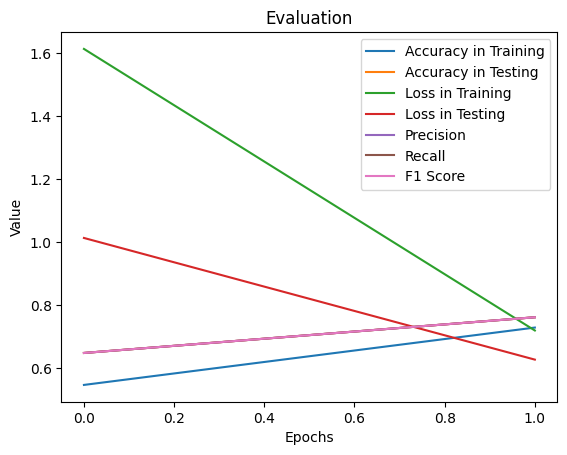

Accuracy in Training: 0.7281666398048401
Accuracy in Testing: 0.7608826160430908
Loss in Training: 0.7188401818275452
Loss in Testing: 0.6264467239379883
Precision: 0.7608826160430908
Recall: 0.7608826160430908
F1 Score: 0.7608826160430908


In [32]:
fig, ax = plt.subplots()

plt.plot(acc_TRAIN, label="Accuracy in Training")
plt.plot(acc_TEST, label="Accuracy in Testing")
plt.plot(loss_TRAIN, label="Loss in Training")
plt.plot(loss_TEST, label="Loss in Testing")
plt.plot(precision_result, label="Precision")
plt.plot(recall_result, label="Recall")
plt.plot(f1_result, label="F1 Score")

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Evaluation")

plt.legend()
plt.savefig("reports_FashionMNIST/raw_model_evaluations_before_al.png")
plt.show()

print(f"Accuracy in Training: {acc_TRAIN[-1]}")
print(f"Accuracy in Testing: {acc_TEST[-1]}")
print(f"Loss in Training: {loss_TRAIN[-1]}")
print(f"Loss in Testing: {loss_TEST[-1]}")
print(f"Precision: {precision_result[-1]}")
print(f"Recall: {recall_result[-1]}")
print(f"F1 Score: {f1_result[-1]}")

In [33]:
torch.manual_seed(42)

In [34]:
def eval_model(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    device: torch.device = device,
):
    model.eval()
    loss = 0
    acc = 0
    f1 = 0
    precision = 0
    recall = 0
    y_pred_list = []
    
    with torch.inference_mode():
        for x, y in tqdm(data_loader):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss += loss_fn(y_pred, y)
            y_pred_list.append(y_pred.argmax(dim=1).cpu().numpy())
            acc += multiclass_accuracy(torch.argmax(y_pred, dim=1), y, num_classes=10)
            f1 += multiclass_f1_score(y_pred.argmax(dim=1), y, num_classes=10)
            precision += multiclass_precision(y_pred.argmax(dim=1), y, num_classes=10)
            recall += multiclass_recall(y_pred.argmax(dim=1), y, num_classes=10)
            
        loss /= len(data_loader)
        acc /= len(data_loader)
        f1 /= len(data_loader)
        precision /= len(data_loader)
        recall /= len(data_loader)
        y_pred_list = np.concatenate(y_pred_list)
        
    return {
        "Model Name": model.__class__.__name__,
        "Model Loss": loss.item(),
        "Model Accuracy": acc,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
    }, y_pred_list

In [35]:
model_results, y_pred = eval_model(model, FashionMNIST_test_data_loader, loss_fn)

  0%|          | 0/313 [00:00<?, ?it/s]

In [36]:
model_results

{'Model Name': 'ResNet',
 'Model Loss': 0.6262400150299072,
 'Model Accuracy': tensor(0.7610, device='cuda:0'),
 'F1 Score': tensor(0.7610, device='cuda:0'),
 'Precision': tensor(0.7610, device='cuda:0'),
 'Recall': tensor(0.7610, device='cuda:0')}

In [37]:
y_pred.shape

(10000,)

## Evaluating Model Visually


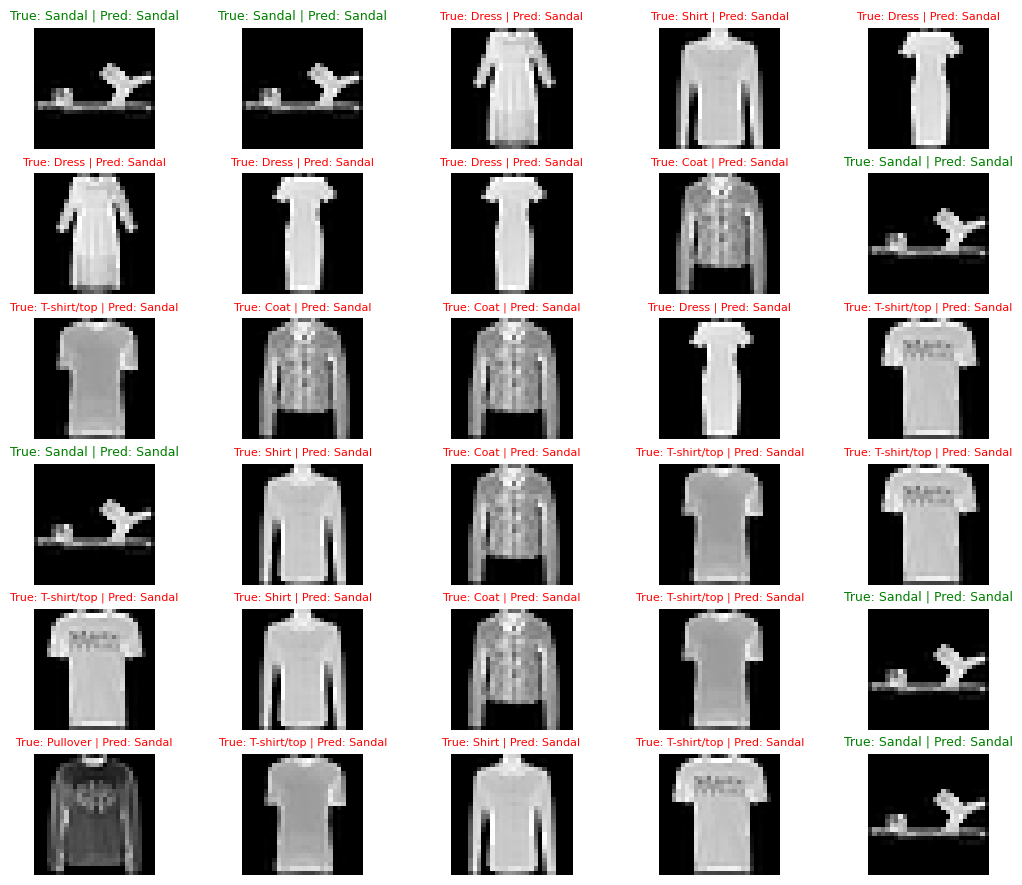

In [38]:
test_samples = []
test_labels = []

for sample, label in random.sample(list(FashionMNIST_test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

rows = 6
cols = 5

plt.figure(figsize=(13, 11))

model.eval()
with torch.inference_mode():
    for i in range(1, rows * cols + 1):
        plt.subplot(rows, cols, i)
        random_index = torch.randint(1, 9, size=[1]).item()
        image, label = test_samples[random_index], test_labels[random_index]
        pred_label = model(image.unsqueeze(0).repeat(1, 3, 1, 1).to(device)).argmax()
        image = image.permute(1, 2, 0).numpy()
        plt.imshow(image, cmap="gray")
        
        if pred_label == label:
            plt.title(f"True: {FashionMNIST_class_names[label]} | Pred: {FashionMNIST_class_names[pred_label]}", c="g", fontsize=9)
        else:
            plt.title(f"True: {FashionMNIST_class_names[label]} | Pred: {FashionMNIST_class_names[pred_label]}", c="r", fontsize=8)
        plt.axis(False)
        
plt.savefig("reports_FashionMNIST/raw_model_predictions_before_al.png")

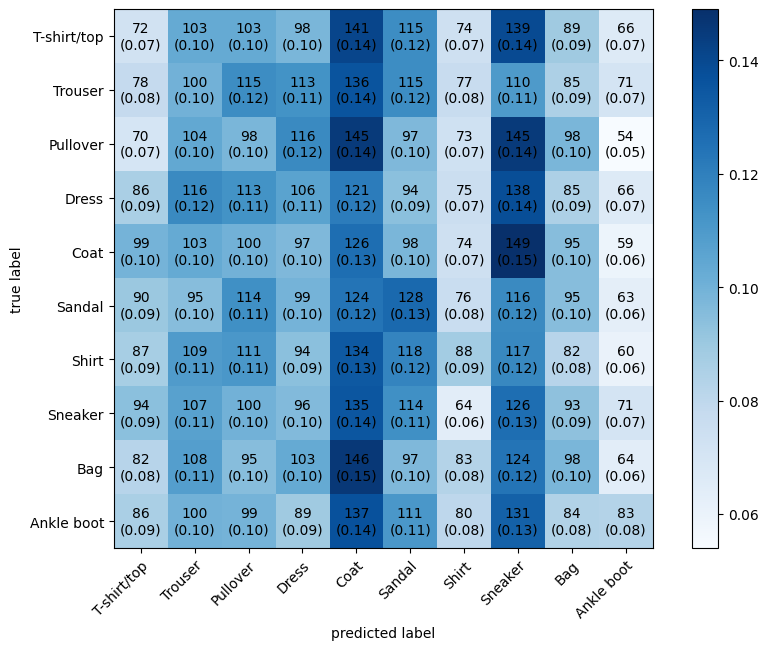

In [39]:
confusion_matrix = multiclass_confusion_matrix(torch.tensor(y_pred), torch.tensor(FashionMNIST_test_data.targets), num_classes=10)
plot_confusion_matrix(
    conf_mat=confusion_matrix.numpy(),
    class_names=FashionMNIST_class_names,
    figsize=(10, 7),
    show_absolute=True,
    show_normed=True,
    colorbar=True,
)

plt.savefig("reports_FashionMNIST/raw_model_confusion_matrix_before_al.png")

## Saving the Model


In [40]:
MODELS_PATH = Path("models")
MODELS_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "base_model.pth"
MODEL_SAVE_PATH = MODELS_PATH / MODEL_NAME

print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to models/base_model.pth


## Load the Model


In [41]:
trained_model = models.resnet50().to(device)
trained_model.fc = nn.Linear(model.fc.in_features, 10)
trained_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
trained_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [42]:
summary(trained_model, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]           4,096
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]          16,384
      BatchNorm2d-12            [-1, 256, 7, 7]             512
           Conv2d-13            [-1, 256, 7, 7]          16,384
      BatchNorm2d-14            [-1, 25

# Active Learning


In [43]:
cycles = 100

In [44]:
trained_model = NeuralNetClassifier(
    trained_model,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    train_split=None,
    verbose=0,
    device=device,
)

In [45]:
trained_model.initialize()

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=

In [46]:
loss_fn = nn.MSELoss()

In [47]:
def active_learning(pool_x, pool_y, method, model_estimator, num_classes, class_names):
    learner = None
    acc_train = []
    acc_test = []
    precision_result = []
    recall_result = []
    f1_result = []
    loss = []
    if method == "uncertainty_sampling":
        learner = ActiveLearner(estimator=model_estimator, query_strategy=uncertainty_sampling)
    elif method == "margin_sampling":
        learner = ActiveLearner(estimator=model_estimator, query_strategy=margin_sampling)
    elif method == "entropy_sampling":
        learner = ActiveLearner(estimator=model_estimator, query_strategy=entropy_sampling)
    elif method == "random_sampling":
        def random_sampling(Learner, pool_x, n_instances):
            n_samples = len(pool_x)
            query_idx = np.random.choice(range(n_samples), size=n_instances, replace=False)
            X_query = pool_x[query_idx]
            return query_idx, X_query

        learner = ActiveLearner(estimator=model_estimator, query_strategy=random_sampling)
    elif method == "query_by_committee":
        n_members = 3
        learner_list = list()
        for member_idx in range(n_members):
            Learner = ActiveLearner(estimator=model_estimator)
            learner_list.append(Learner)
        learner = Committee(learner_list=learner_list, query_strategy=vote_entropy_sampling)
    else:
        print("Invalid Input")
        
    print(f"Starting Active Learning with {method.replace('_', ' ')} method")

    for cycle in range(cycles):
        print(f"Cycle: {cycle + 1}")
        query_idx, _ = learner.query(pool_x, n_instances=100)
        learner.teach(X=pool_x[query_idx], y=pool_y[query_idx])
        pool_x = np.delete(pool_x, query_idx, axis=0)
        pool_y = np.delete(pool_y, query_idx, axis=0)

        model_accuracy = learner.score(x_train, y_train)
        acc_train.append(model_accuracy)
        y_pred = learner.predict(x_test)

        acc_test.append(
            multiclass_accuracy(
                torch.tensor(y_pred), torch.tensor(y_test), num_classes=num_classes
            )
        )
        precision_result.append(
            multiclass_precision(
                torch.tensor(y_pred), torch.tensor(y_test), num_classes=num_classes
            )
        )
        recall_result.append(
            multiclass_recall(
                torch.tensor(y_pred), torch.tensor(y_test), num_classes=num_classes
            )
        )
        f1_result.append(
            multiclass_f1_score(
                torch.tensor(y_pred), torch.tensor(y_test), num_classes=num_classes
            )
        )
        loss.append(
            loss_fn(
                torch.tensor(y_pred, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)
            )
        )

        print(f"\tTraining Accuracy: {acc_train[-1]:.3f}")
        print(f"\tTesting Accuracy: {acc_test[-1]:.3f}")
        print(f"\tPrecision: {precision_result[-1]:.3f}")
        print(f"\tRecall: {recall_result[-1]:.3f}")
        print(f"\tF1 Score: {f1_result[-1]:.3f}")
        print(f"\tLoss: {loss[-1]:.3f}")
        
        try:
            slope = (loss[-1] - loss[-10]) / 9
            print("\tSlop after 10 Epochs", slope)
            if slope >= 0.01:
                break
        except Exception:
            continue

    print(f"Active Learning with {method} method is finished")
    confusion_matrix = multiclass_confusion_matrix(
        torch.tensor(y_pred), torch.tensor(y_test), num_classes=num_classes
    )
    plot_confusion_matrix(
        conf_mat=confusion_matrix.numpy(),
        class_names=class_names,
        figsize=(10, 7),
        show_absolute=True,
        show_normed=True,
        colorbar=True,
    )

    plt.savefig(f"reports_FashionMNIST/{method}_confusion_matrix_after_al.png")
    return {
        "Train Accuracy": acc_train,
        "Test Accuracy": acc_test,
        "Precision": precision_result,
        "Recall": recall_result,
        "F1 Score": f1_result,
        "Loss": loss
    }

## Random Sampling

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


Starting Active Learning with random sampling method
Cycle: 1


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.364
	Testing Accuracy: 0.359
	Precision: 0.359
	Recall: 0.359
	F1 Score: 0.359
	Loss: 4.757
Cycle: 2


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.622
	Testing Accuracy: 0.619
	Precision: 0.619
	Recall: 0.619
	F1 Score: 0.619
	Loss: 5.192
Cycle: 3


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.720
	Testing Accuracy: 0.711
	Precision: 0.711
	Recall: 0.711
	F1 Score: 0.712
	Loss: 3.412
Cycle: 4


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.739
	Testing Accuracy: 0.731
	Precision: 0.731
	Recall: 0.731
	F1 Score: 0.731
	Loss: 3.207
Cycle: 5


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.761
	Testing Accuracy: 0.751
	Precision: 0.751
	Recall: 0.751
	F1 Score: 0.751
	Loss: 3.289
Cycle: 6


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.762
	Testing Accuracy: 0.753
	Precision: 0.753
	Recall: 0.753
	F1 Score: 0.753
	Loss: 2.981
Cycle: 7


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.771
	Testing Accuracy: 0.762
	Precision: 0.762
	Recall: 0.762
	F1 Score: 0.762
	Loss: 3.281
Cycle: 8


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.782
	Testing Accuracy: 0.773
	Precision: 0.773
	Recall: 0.773
	F1 Score: 0.773
	Loss: 3.028
Cycle: 9


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.791
	Testing Accuracy: 0.779
	Precision: 0.779
	Recall: 0.779
	F1 Score: 0.779
	Loss: 2.970
Cycle: 10


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.789
	Testing Accuracy: 0.776
	Precision: 0.776
	Recall: 0.776
	F1 Score: 0.776
	Loss: 3.166
	Slop after 10 Epochs tensor(-0.1768)
Cycle: 11


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.806
	Testing Accuracy: 0.795
	Precision: 0.795
	Recall: 0.795
	F1 Score: 0.795
	Loss: 2.733
	Slop after 10 Epochs tensor(-0.2732)
Cycle: 12


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.794
	Testing Accuracy: 0.782
	Precision: 0.782
	Recall: 0.782
	F1 Score: 0.782
	Loss: 2.599
	Slop after 10 Epochs tensor(-0.0903)
Cycle: 13


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.816
	Testing Accuracy: 0.804
	Precision: 0.804
	Recall: 0.804
	F1 Score: 0.804
	Loss: 2.602
	Slop after 10 Epochs tensor(-0.0672)
Cycle: 14


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.812
	Testing Accuracy: 0.804
	Precision: 0.804
	Recall: 0.804
	F1 Score: 0.804
	Loss: 2.555
	Slop after 10 Epochs tensor(-0.0816)
Cycle: 15


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.807
	Testing Accuracy: 0.801
	Precision: 0.801
	Recall: 0.801
	F1 Score: 0.801
	Loss: 2.704
	Slop after 10 Epochs tensor(-0.0308)
Cycle: 16


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.821
	Testing Accuracy: 0.811
	Precision: 0.811
	Recall: 0.811
	F1 Score: 0.811
	Loss: 2.568
	Slop after 10 Epochs tensor(-0.0792)
Cycle: 17


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.812
	Testing Accuracy: 0.800
	Precision: 0.800
	Recall: 0.800
	F1 Score: 0.800
	Loss: 2.505
	Slop after 10 Epochs tensor(-0.0581)
Cycle: 18


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.821
	Testing Accuracy: 0.809
	Precision: 0.809
	Recall: 0.809
	F1 Score: 0.809
	Loss: 2.567
	Slop after 10 Epochs tensor(-0.0447)
Cycle: 19


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.818
	Testing Accuracy: 0.806
	Precision: 0.806
	Recall: 0.806
	F1 Score: 0.806
	Loss: 2.491
	Slop after 10 Epochs tensor(-0.0749)
Cycle: 20
	Training Accuracy: 0.722
	Testing Accuracy: 0.711
	Precision: 0.711
	Recall: 0.711
	F1 Score: 0.711
	Loss: 3.716
	Slop after 10 Epochs tensor(0.1091)
Active Learning with random_sampling method is finished


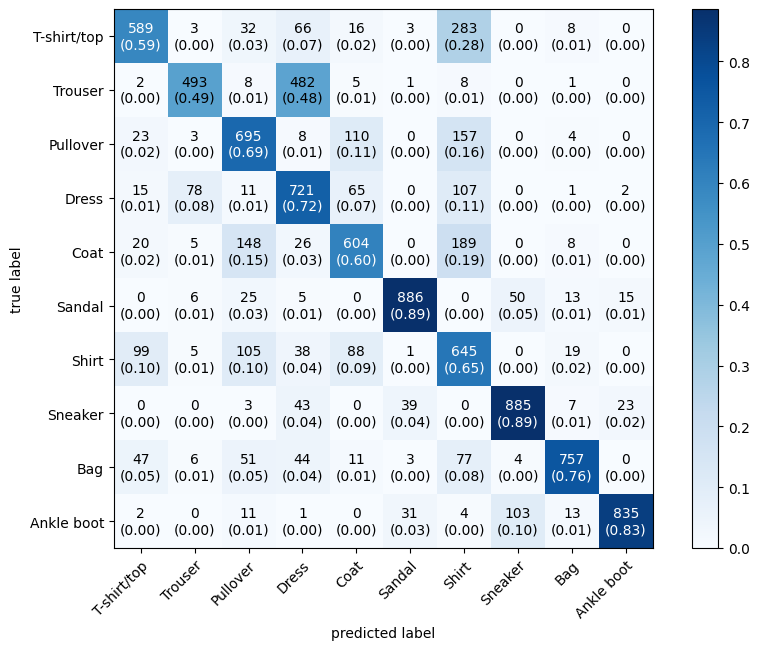

In [48]:
results_random_sampling = active_learning(x_pool, y_pool, "random_sampling", trained_model, 10, FashionMNIST_class_names)

## Uncertainty Sampling

Starting Active Learning with uncertainty sampling method
Cycle: 1


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.693
	Testing Accuracy: 0.690
	Precision: 0.690
	Recall: 0.690
	F1 Score: 0.690
	Loss: 4.785
Cycle: 2


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.767
	Testing Accuracy: 0.758
	Precision: 0.758
	Recall: 0.758
	F1 Score: 0.758
	Loss: 2.993
Cycle: 3


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.749
	Testing Accuracy: 0.737
	Precision: 0.737
	Recall: 0.737
	F1 Score: 0.737
	Loss: 4.922
Cycle: 4


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.773
	Testing Accuracy: 0.760
	Precision: 0.760
	Recall: 0.760
	F1 Score: 0.760
	Loss: 3.997
Cycle: 5


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.794
	Testing Accuracy: 0.785
	Precision: 0.785
	Recall: 0.785
	F1 Score: 0.785
	Loss: 3.078
Cycle: 6


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.804
	Testing Accuracy: 0.796
	Precision: 0.796
	Recall: 0.796
	F1 Score: 0.796
	Loss: 2.922
Cycle: 7


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.802
	Testing Accuracy: 0.793
	Precision: 0.793
	Recall: 0.793
	F1 Score: 0.793
	Loss: 3.365
Cycle: 8


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.783
	Testing Accuracy: 0.768
	Precision: 0.768
	Recall: 0.768
	F1 Score: 0.768
	Loss: 4.017
Cycle: 9


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.799
	Testing Accuracy: 0.788
	Precision: 0.788
	Recall: 0.788
	F1 Score: 0.788
	Loss: 3.152
Cycle: 10


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.827
	Testing Accuracy: 0.819
	Precision: 0.819
	Recall: 0.819
	F1 Score: 0.819
	Loss: 2.370
	Slop after 10 Epochs tensor(-0.2684)
Cycle: 11


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.828
	Testing Accuracy: 0.818
	Precision: 0.818
	Recall: 0.818
	F1 Score: 0.818
	Loss: 2.266
	Slop after 10 Epochs tensor(-0.0807)
Cycle: 12


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.825
	Testing Accuracy: 0.809
	Precision: 0.809
	Recall: 0.809
	F1 Score: 0.809
	Loss: 2.509
	Slop after 10 Epochs tensor(-0.2681)
Cycle: 13


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.822
	Testing Accuracy: 0.811
	Precision: 0.811
	Recall: 0.811
	F1 Score: 0.811
	Loss: 2.364
	Slop after 10 Epochs tensor(-0.1815)
Cycle: 14


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.846
	Testing Accuracy: 0.831
	Precision: 0.831
	Recall: 0.831
	F1 Score: 0.831
	Loss: 2.110
	Slop after 10 Epochs tensor(-0.1075)
Cycle: 15


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.842
	Testing Accuracy: 0.829
	Precision: 0.829
	Recall: 0.829
	F1 Score: 0.829
	Loss: 2.076
	Slop after 10 Epochs tensor(-0.0940)
Cycle: 16


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.841
	Testing Accuracy: 0.819
	Precision: 0.819
	Recall: 0.819
	F1 Score: 0.819
	Loss: 2.145
	Slop after 10 Epochs tensor(-0.1355)
Cycle: 17


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.810
	Testing Accuracy: 0.797
	Precision: 0.797
	Recall: 0.797
	F1 Score: 0.797
	Loss: 2.408
	Slop after 10 Epochs tensor(-0.1787)
Cycle: 18


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.847
	Testing Accuracy: 0.829
	Precision: 0.829
	Recall: 0.829
	F1 Score: 0.829
	Loss: 2.042
	Slop after 10 Epochs tensor(-0.1234)
Cycle: 19


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.836
	Testing Accuracy: 0.820
	Precision: 0.820
	Recall: 0.820
	F1 Score: 0.820
	Loss: 2.389
	Slop after 10 Epochs tensor(0.0022)
Cycle: 20


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.863
	Testing Accuracy: 0.845
	Precision: 0.845
	Recall: 0.845
	F1 Score: 0.845
	Loss: 1.999
	Slop after 10 Epochs tensor(-0.0297)
Cycle: 21


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.864
	Testing Accuracy: 0.844
	Precision: 0.844
	Recall: 0.844
	F1 Score: 0.844
	Loss: 2.201
	Slop after 10 Epochs tensor(-0.0342)
Cycle: 22


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.860
	Testing Accuracy: 0.840
	Precision: 0.840
	Recall: 0.840
	F1 Score: 0.840
	Loss: 2.078
	Slop after 10 Epochs tensor(-0.0318)
Cycle: 23


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.868
	Testing Accuracy: 0.846
	Precision: 0.846
	Recall: 0.846
	F1 Score: 0.846
	Loss: 2.073
	Slop after 10 Epochs tensor(-0.0041)
Cycle: 24


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.858
	Testing Accuracy: 0.833
	Precision: 0.833
	Recall: 0.833
	F1 Score: 0.833
	Loss: 2.426
	Slop after 10 Epochs tensor(0.0389)
Active Learning with uncertainty_sampling method is finished


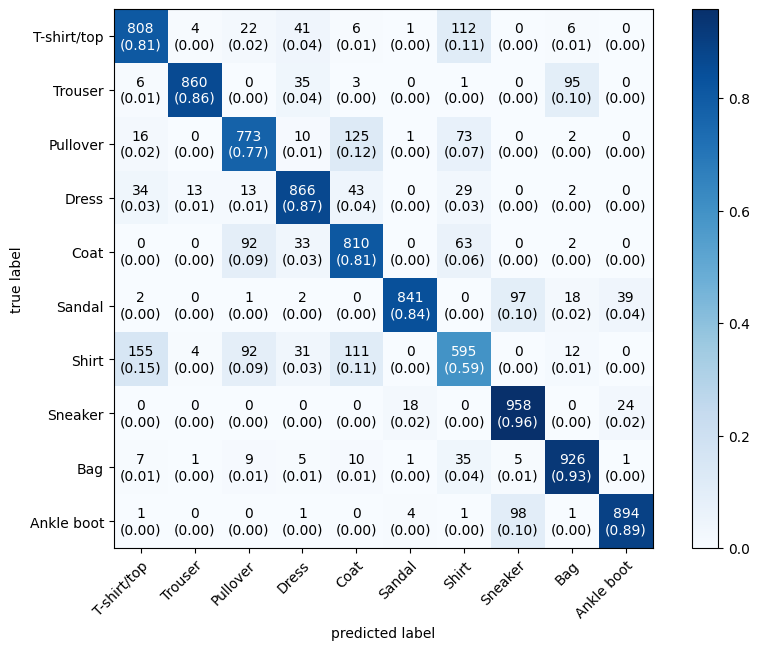

In [49]:
results_uncertainty_sampling = active_learning(x_pool, y_pool, "uncertainty_sampling", trained_model, 10, FashionMNIST_class_names)

## Margin Sampling

Starting Active Learning with margin sampling method
Cycle: 1


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.752
	Testing Accuracy: 0.736
	Precision: 0.736
	Recall: 0.736
	F1 Score: 0.736
	Loss: 2.992
Cycle: 2


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.799
	Testing Accuracy: 0.778
	Precision: 0.778
	Recall: 0.778
	F1 Score: 0.778
	Loss: 2.657
Cycle: 3


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.718
	Testing Accuracy: 0.701
	Precision: 0.701
	Recall: 0.701
	F1 Score: 0.701
	Loss: 3.579
Cycle: 4


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.846
	Testing Accuracy: 0.830
	Precision: 0.830
	Recall: 0.830
	F1 Score: 0.830
	Loss: 2.105
Cycle: 5


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.812
	Testing Accuracy: 0.791
	Precision: 0.791
	Recall: 0.791
	F1 Score: 0.791
	Loss: 4.109
Cycle: 6


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.851
	Testing Accuracy: 0.836
	Precision: 0.836
	Recall: 0.836
	F1 Score: 0.836
	Loss: 2.131
Cycle: 7


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.860
	Testing Accuracy: 0.839
	Precision: 0.839
	Recall: 0.839
	F1 Score: 0.839
	Loss: 2.064
Cycle: 8


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.840
	Testing Accuracy: 0.820
	Precision: 0.820
	Recall: 0.820
	F1 Score: 0.820
	Loss: 2.701
Cycle: 9


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.840
	Testing Accuracy: 0.820
	Precision: 0.820
	Recall: 0.820
	F1 Score: 0.820
	Loss: 2.555
Cycle: 10


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.841
	Testing Accuracy: 0.820
	Precision: 0.820
	Recall: 0.820
	F1 Score: 0.820
	Loss: 3.927
	Slop after 10 Epochs tensor(0.1039)
Active Learning with margin_sampling method is finished


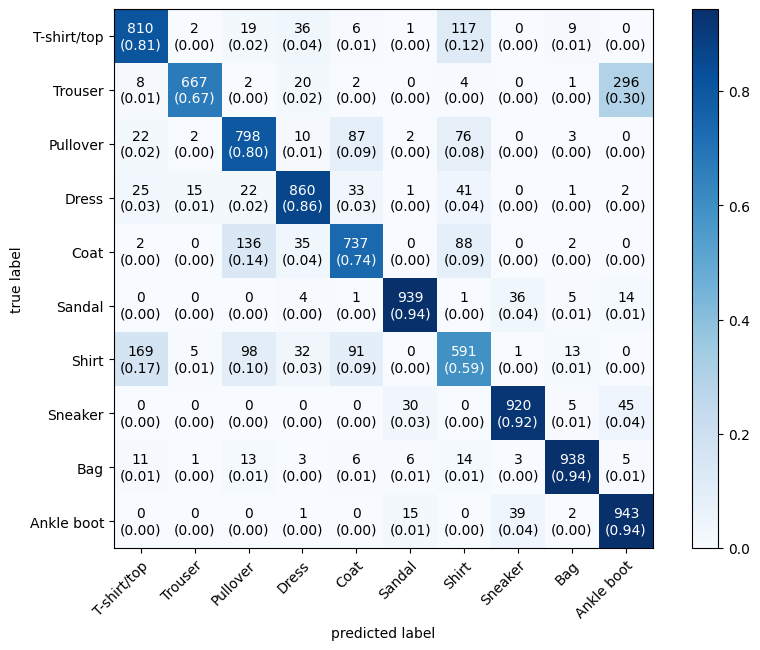

In [50]:
results_margin_sampling = active_learning(x_pool, y_pool, "margin_sampling", trained_model, 10, FashionMNIST_class_names)

## Entropy Sampling

Starting Active Learning with entropy sampling method
Cycle: 1


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.719
	Testing Accuracy: 0.707
	Precision: 0.707
	Recall: 0.707
	F1 Score: 0.707
	Loss: 6.208
Cycle: 2


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.717
	Testing Accuracy: 0.709
	Precision: 0.709
	Recall: 0.709
	F1 Score: 0.709
	Loss: 5.801
Cycle: 3


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.741
	Testing Accuracy: 0.731
	Precision: 0.731
	Recall: 0.731
	F1 Score: 0.731
	Loss: 4.370
Cycle: 4


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.781
	Testing Accuracy: 0.767
	Precision: 0.767
	Recall: 0.767
	F1 Score: 0.767
	Loss: 3.021
Cycle: 5


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.846
	Testing Accuracy: 0.829
	Precision: 0.829
	Recall: 0.829
	F1 Score: 0.829
	Loss: 2.189
Cycle: 6


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.838
	Testing Accuracy: 0.825
	Precision: 0.825
	Recall: 0.825
	F1 Score: 0.825
	Loss: 2.303
Cycle: 7


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.839
	Testing Accuracy: 0.826
	Precision: 0.826
	Recall: 0.826
	F1 Score: 0.826
	Loss: 2.319
Cycle: 8


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.825
	Testing Accuracy: 0.805
	Precision: 0.805
	Recall: 0.805
	F1 Score: 0.805
	Loss: 2.912
Cycle: 9


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.835
	Testing Accuracy: 0.816
	Precision: 0.816
	Recall: 0.816
	F1 Score: 0.816
	Loss: 2.534
Cycle: 10


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.855
	Testing Accuracy: 0.834
	Precision: 0.834
	Recall: 0.834
	F1 Score: 0.834
	Loss: 2.175
	Slop after 10 Epochs tensor(-0.4481)
Cycle: 11


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.862
	Testing Accuracy: 0.841
	Precision: 0.841
	Recall: 0.841
	F1 Score: 0.841
	Loss: 2.163
	Slop after 10 Epochs tensor(-0.4043)
Cycle: 12


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.835
	Testing Accuracy: 0.823
	Precision: 0.823
	Recall: 0.823
	F1 Score: 0.823
	Loss: 3.013
	Slop after 10 Epochs tensor(-0.1508)
Cycle: 13


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.855
	Testing Accuracy: 0.833
	Precision: 0.833
	Recall: 0.833
	F1 Score: 0.833
	Loss: 2.527
	Slop after 10 Epochs tensor(-0.0549)
Cycle: 14


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.869
	Testing Accuracy: 0.851
	Precision: 0.851
	Recall: 0.851
	F1 Score: 0.851
	Loss: 2.041
	Slop after 10 Epochs tensor(-0.0165)
Cycle: 15


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.852
	Testing Accuracy: 0.835
	Precision: 0.835
	Recall: 0.835
	F1 Score: 0.835
	Loss: 2.203
	Slop after 10 Epochs tensor(-0.0110)
Cycle: 16


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.864
	Testing Accuracy: 0.843
	Precision: 0.843
	Recall: 0.843
	F1 Score: 0.843
	Loss: 2.075
	Slop after 10 Epochs tensor(-0.0271)
Cycle: 17


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.860
	Testing Accuracy: 0.833
	Precision: 0.833
	Recall: 0.833
	F1 Score: 0.833
	Loss: 2.372
	Slop after 10 Epochs tensor(-0.0600)
Cycle: 18


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.866
	Testing Accuracy: 0.845
	Precision: 0.845
	Recall: 0.845
	F1 Score: 0.845
	Loss: 2.084
	Slop after 10 Epochs tensor(-0.0499)
Cycle: 19


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.868
	Testing Accuracy: 0.844
	Precision: 0.844
	Recall: 0.844
	F1 Score: 0.844
	Loss: 1.983
	Slop after 10 Epochs tensor(-0.0214)
Cycle: 20


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.850
	Testing Accuracy: 0.829
	Precision: 0.829
	Recall: 0.829
	F1 Score: 0.829
	Loss: 2.554
	Slop after 10 Epochs tensor(0.0435)
Active Learning with entropy_sampling method is finished


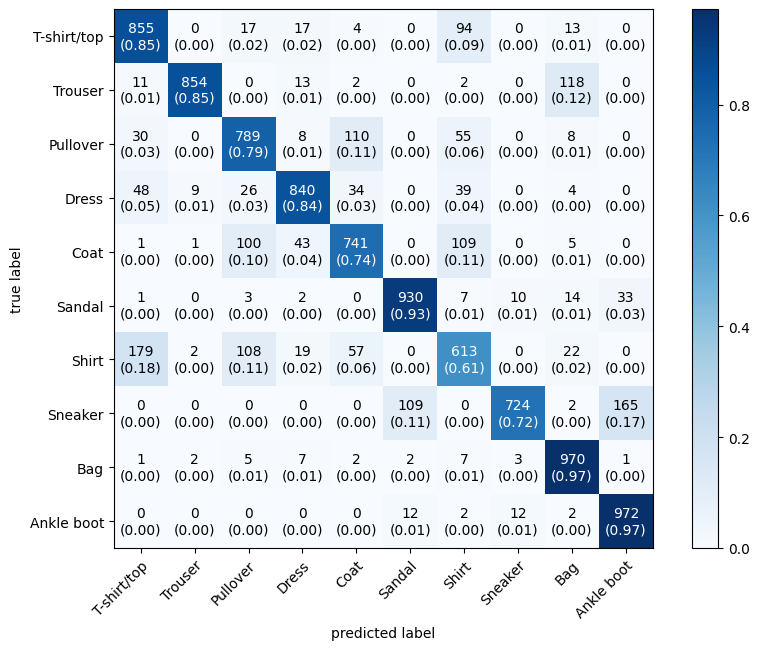

In [51]:
results_entropy_sampling = active_learning(x_pool, y_pool, "entropy_sampling", trained_model, 10, FashionMNIST_class_names)

## Query by Committee

Starting Active Learning with query by committee method
Cycle: 1


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.824
	Testing Accuracy: 0.810
	Precision: 0.810
	Recall: 0.810
	F1 Score: 0.810
	Loss: 2.538
Cycle: 2


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.811
	Testing Accuracy: 0.802
	Precision: 0.802
	Recall: 0.802
	F1 Score: 0.802
	Loss: 2.490
Cycle: 3


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.814
	Testing Accuracy: 0.805
	Precision: 0.805
	Recall: 0.805
	F1 Score: 0.805
	Loss: 2.666
Cycle: 4


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.803
	Testing Accuracy: 0.790
	Precision: 0.790
	Recall: 0.790
	F1 Score: 0.790
	Loss: 2.631
Cycle: 5


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.820
	Testing Accuracy: 0.809
	Precision: 0.809
	Recall: 0.809
	F1 Score: 0.809
	Loss: 2.453
Cycle: 6


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.831
	Testing Accuracy: 0.818
	Precision: 0.818
	Recall: 0.818
	F1 Score: 0.818
	Loss: 2.508
Cycle: 7


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.835
	Testing Accuracy: 0.825
	Precision: 0.825
	Recall: 0.825
	F1 Score: 0.825
	Loss: 2.279
Cycle: 8


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.811
	Testing Accuracy: 0.800
	Precision: 0.800
	Recall: 0.800
	F1 Score: 0.800
	Loss: 2.536
Cycle: 9


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.819
	Testing Accuracy: 0.808
	Precision: 0.808
	Recall: 0.808
	F1 Score: 0.808
	Loss: 2.545
Cycle: 10


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.816
	Testing Accuracy: 0.803
	Precision: 0.803
	Recall: 0.803
	F1 Score: 0.803
	Loss: 2.501
	Slop after 10 Epochs tensor(-0.0041)
Cycle: 11


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.826
	Testing Accuracy: 0.813
	Precision: 0.813
	Recall: 0.813
	F1 Score: 0.813
	Loss: 2.596
	Slop after 10 Epochs tensor(0.0119)
Active Learning with query_by_committee method is finished


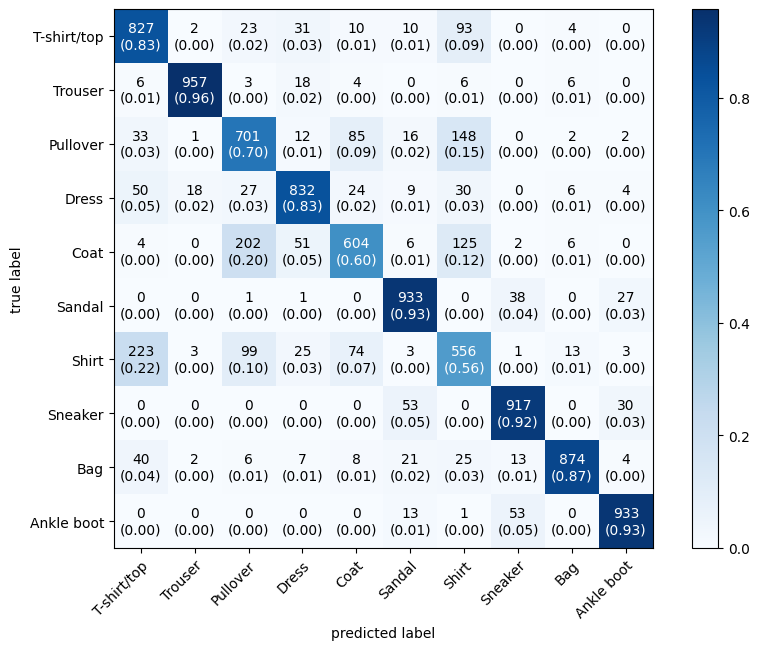

In [52]:
results_committee_sampling = active_learning(x_pool, y_pool, "query_by_committee", trained_model, 10, FashionMNIST_class_names)

# Plot All Metrics


## Accuracy


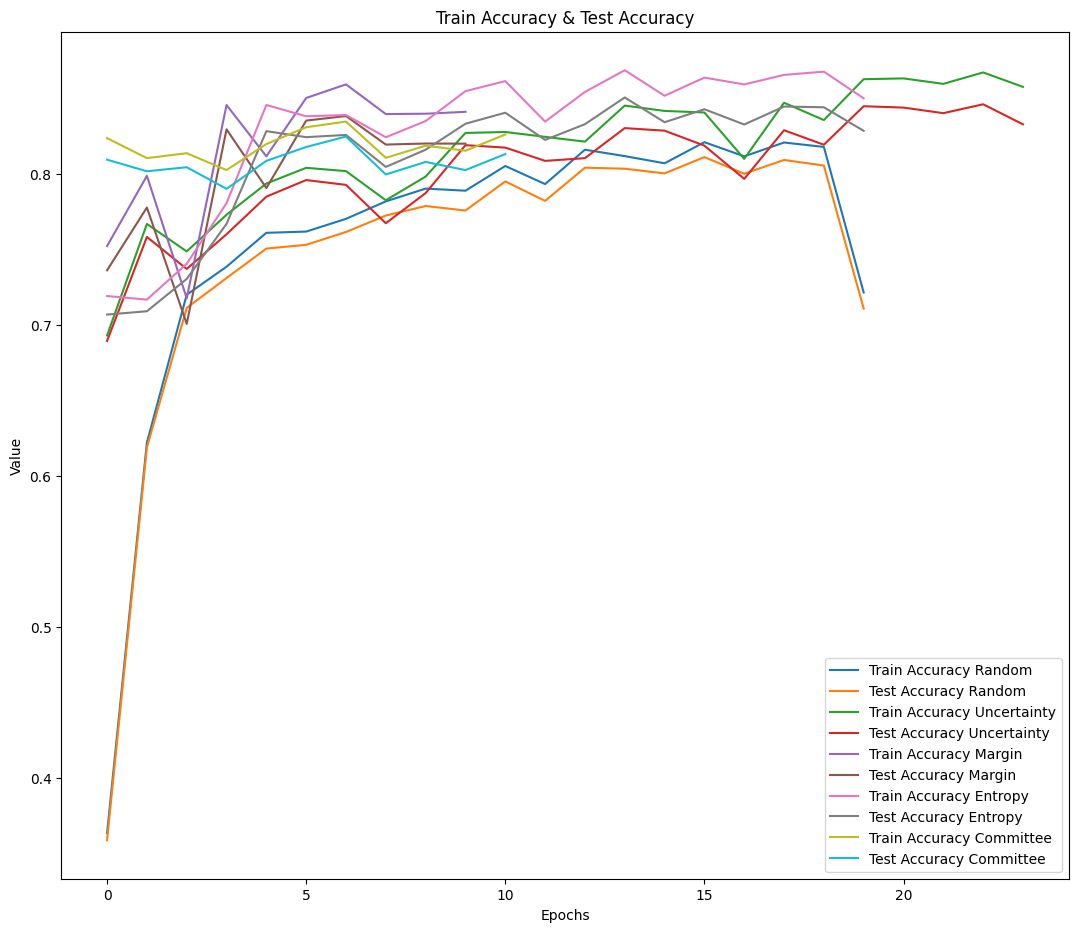

Train Accuracy Random: 0.7217
Test Accuracy Random: 0.7110000252723694
Train Accuracy Uncertainty: 0.8579
Test Accuracy Uncertainty: 0.8331000208854675
Train Accuracy Margin: 0.8414
Test Accuracy Margin: 0.8202999830245972
Train Accuracy Entropy: 0.8503166666666667
Test Accuracy Entropy: 0.8288000226020813
Train Accuracy Committee: 0.8263833333333334
Test Accuracy Committee: 0.8133999705314636


In [53]:
plt.figure(figsize=(13, 11))

plt.plot(results_random_sampling["Train Accuracy"], label="Train Accuracy Random")
plt.plot(results_random_sampling["Test Accuracy"], label="Test Accuracy Random")
plt.plot(results_uncertainty_sampling["Train Accuracy"], label="Train Accuracy Uncertainty")
plt.plot(results_uncertainty_sampling["Test Accuracy"], label="Test Accuracy Uncertainty")
plt.plot(results_margin_sampling["Train Accuracy"], label="Train Accuracy Margin")
plt.plot(results_margin_sampling["Test Accuracy"], label="Test Accuracy Margin")
plt.plot(results_entropy_sampling["Train Accuracy"], label="Train Accuracy Entropy")
plt.plot(results_entropy_sampling["Test Accuracy"], label="Test Accuracy Entropy")
plt.plot(results_committee_sampling["Train Accuracy"], label="Train Accuracy Committee")
plt.plot(results_committee_sampling["Test Accuracy"], label="Test Accuracy Committee")

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Train Accuracy & Test Accuracy")
plt.legend()
plt.savefig("reports_FashionMNIST/model_after_al_accuracy.png")
plt.show()

print(f"Train Accuracy Random: {results_random_sampling['Train Accuracy'][-1]}")
print(f"Test Accuracy Random: {results_random_sampling['Test Accuracy'][-1]}")
print(f"Train Accuracy Uncertainty: {results_uncertainty_sampling['Train Accuracy'][-1]}")
print(f"Test Accuracy Uncertainty: {results_uncertainty_sampling['Test Accuracy'][-1]}")
print(f"Train Accuracy Margin: {results_margin_sampling['Train Accuracy'][-1]}")
print(f"Test Accuracy Margin: {results_margin_sampling['Test Accuracy'][-1]}")
print(f"Train Accuracy Entropy: {results_entropy_sampling['Train Accuracy'][-1]}")
print(f"Test Accuracy Entropy: {results_entropy_sampling['Test Accuracy'][-1]}")
print(f"Train Accuracy Committee: {results_committee_sampling['Train Accuracy'][-1]}")
print(f"Test Accuracy Committee: {results_committee_sampling['Test Accuracy'][-1]}")

## Loss

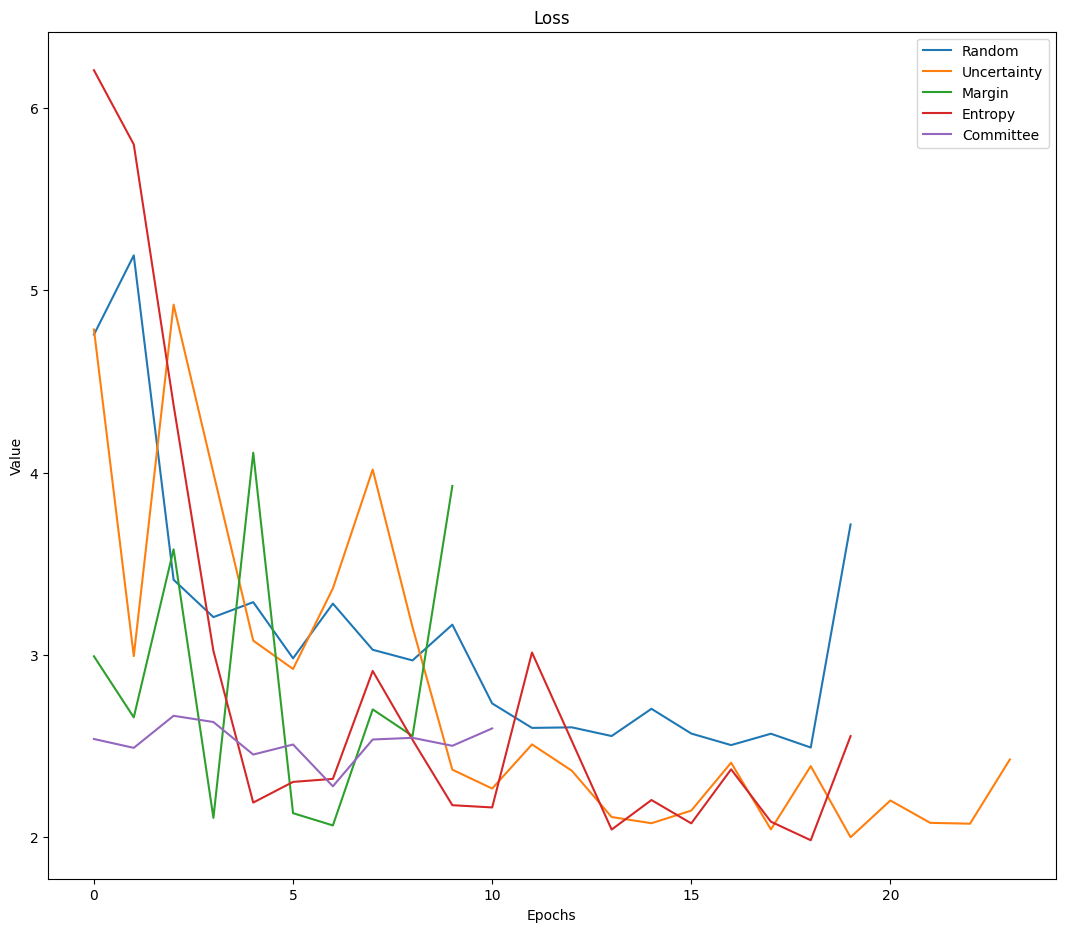

Random: 3.71560001373291
Uncertainty: 2.4260001182556152
Margin: 3.9268999099731445
Entropy: 2.553999900817871
Committee: 2.596299886703491


In [54]:
plt.figure(figsize=(13, 11))

plt.plot(results_random_sampling["Loss"], label="Random")
plt.plot(results_uncertainty_sampling["Loss"], label="Uncertainty")
plt.plot(results_margin_sampling["Loss"], label="Margin")
plt.plot(results_entropy_sampling["Loss"], label="Entropy")
plt.plot(results_committee_sampling["Loss"], label="Committee")

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Loss")
plt.legend()
plt.savefig("reports_FashionMNIST/model_after_al_loss.png")
plt.show()

print(f"Random: {results_random_sampling['Loss'][-1]}")
print(f"Uncertainty: {results_uncertainty_sampling['Loss'][-1]}")
print(f"Margin: {results_margin_sampling['Loss'][-1]}")
print(f"Entropy: {results_entropy_sampling['Loss'][-1]}")
print(f"Committee: {results_committee_sampling['Loss'][-1]}")

## Precision


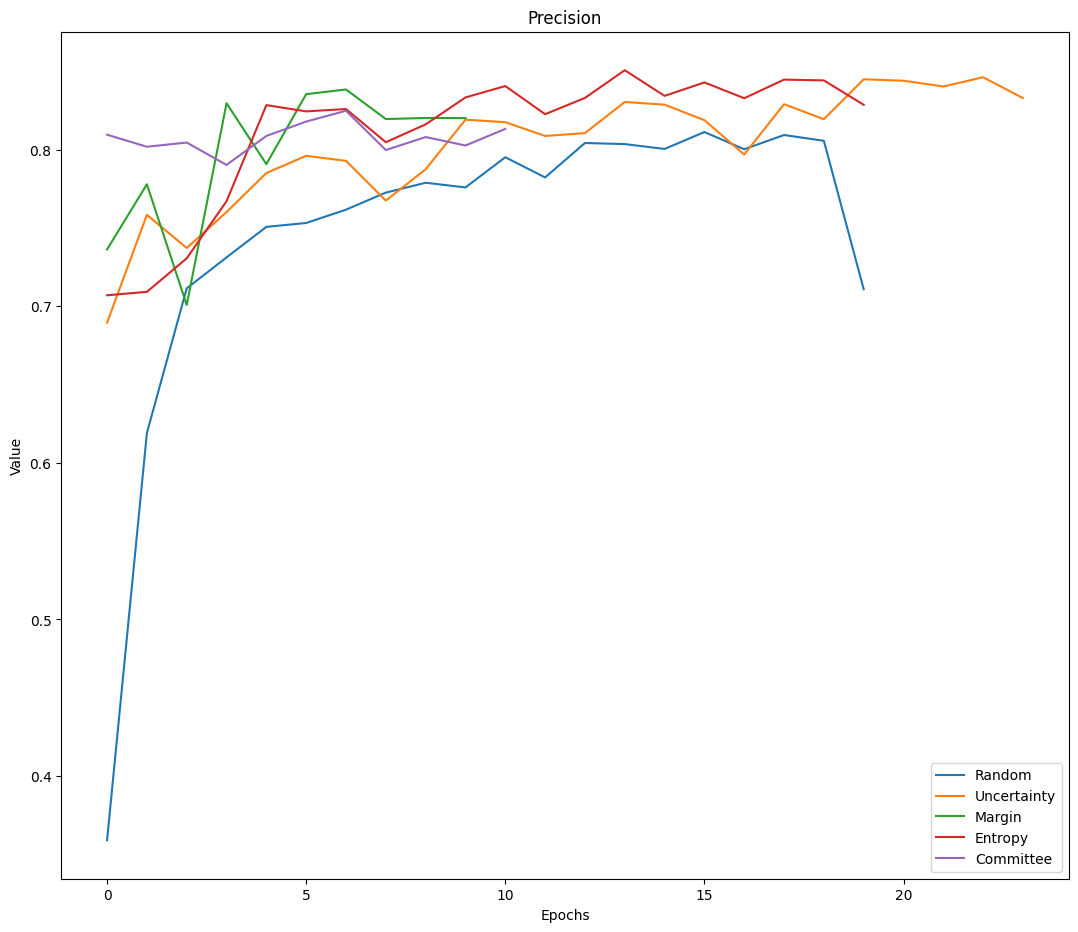

Random: 0.7110000252723694
Uncertainty: 0.8331000208854675
Margin: 0.8202999830245972
Entropy: 0.8288000226020813
Committee: 0.8133999705314636


In [55]:
plt.figure(figsize=(13, 11))

plt.plot(results_random_sampling["Precision"], label="Random")
plt.plot(results_uncertainty_sampling["Precision"], label="Uncertainty")
plt.plot(results_margin_sampling["Precision"], label="Margin")
plt.plot(results_entropy_sampling["Precision"], label="Entropy")
plt.plot(results_committee_sampling["Precision"], label="Committee")

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Precision")
plt.legend()
plt.savefig("reports_FashionMNIST/model_after_al_precision.png")
plt.show()

print(f"Random: {results_random_sampling['Precision'][-1]}")
print(f"Uncertainty: {results_uncertainty_sampling['Precision'][-1]}")
print(f"Margin: {results_margin_sampling['Precision'][-1]}")
print(f"Entropy: {results_entropy_sampling['Precision'][-1]}")
print(f"Committee: {results_committee_sampling['Precision'][-1]}")

## Recall


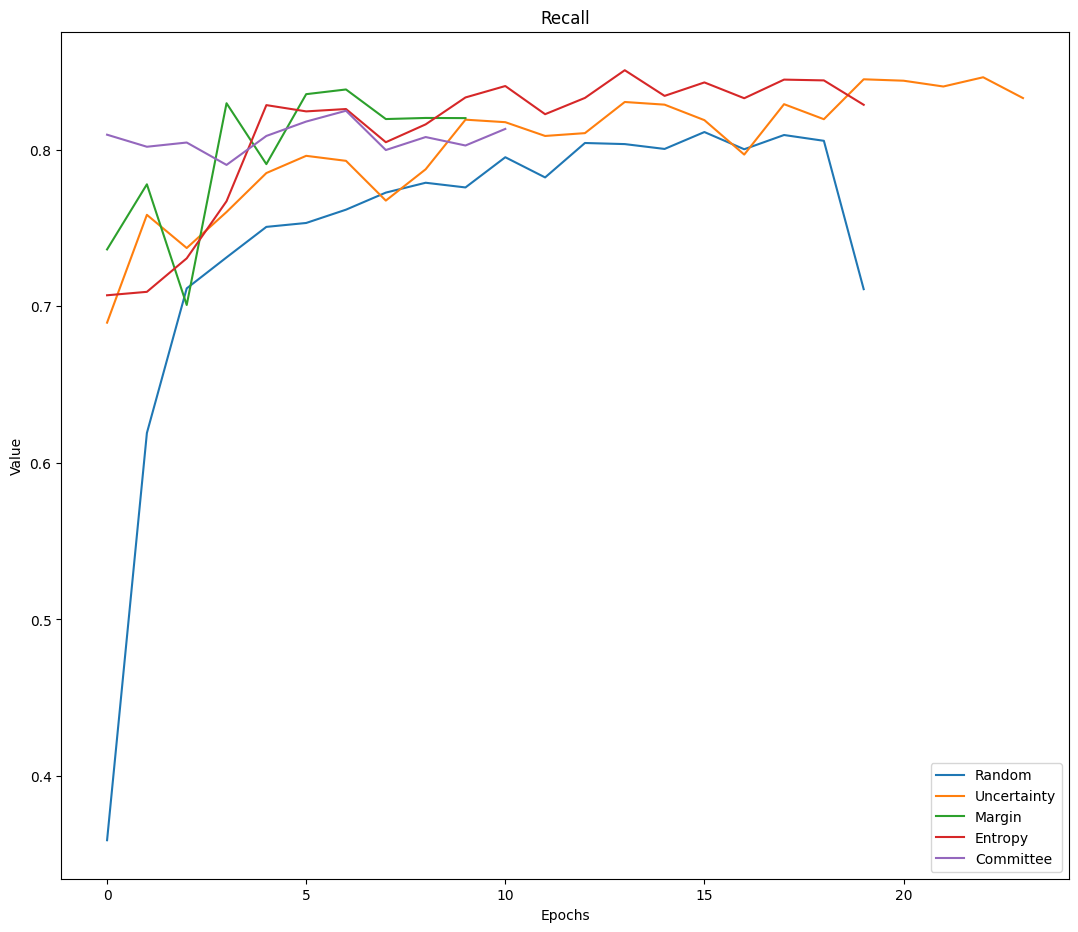

Random: 0.7110000252723694
Uncertainty: 0.8331000208854675
Margin: 0.8202999830245972
Entropy: 0.8288000226020813
Committee: 0.8133999705314636


In [56]:
plt.figure(figsize=(13, 11))

plt.plot(results_random_sampling["Recall"], label="Random")
plt.plot(results_uncertainty_sampling["Recall"], label="Uncertainty")
plt.plot(results_margin_sampling["Recall"], label="Margin")
plt.plot(results_entropy_sampling["Recall"], label="Entropy")
plt.plot(results_committee_sampling["Recall"], label="Committee")

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Recall")
plt.legend()
plt.savefig("reports_FashionMNIST/model_after_al_recall.png")
plt.show()

print(f"Random: {results_random_sampling['Recall'][-1]}")
print(f"Uncertainty: {results_uncertainty_sampling['Recall'][-1]}")
print(f"Margin: {results_margin_sampling['Recall'][-1]}")
print(f"Entropy: {results_entropy_sampling['Recall'][-1]}")
print(f"Committee: {results_committee_sampling['Recall'][-1]}")

## F1 Score


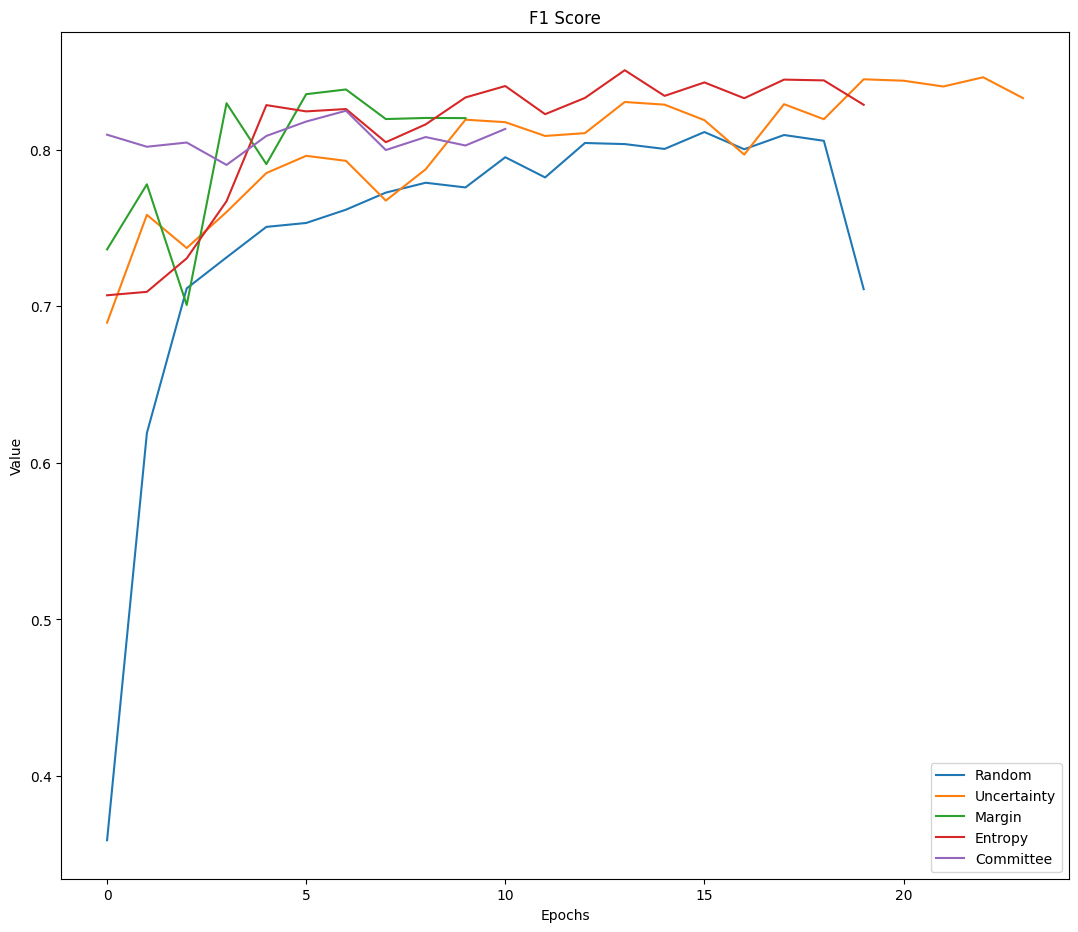

Random: 0.7110000848770142
Uncertainty: 0.8330999612808228
Margin: 0.8202999234199524
Entropy: 0.8288000226020813
Committee: 0.8133999109268188


In [57]:
plt.figure(figsize=(13, 11))

plt.plot(results_random_sampling["F1 Score"], label="Random")
plt.plot(results_uncertainty_sampling["F1 Score"], label="Uncertainty")
plt.plot(results_margin_sampling["F1 Score"], label="Margin")
plt.plot(results_entropy_sampling["F1 Score"], label="Entropy")
plt.plot(results_committee_sampling["F1 Score"], label="Committee")

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("F1 Score")
plt.legend()
plt.savefig("reports_FashionMNIST/model_after_al_f1_score.png")
plt.show()

print(f"Random: {results_random_sampling['F1 Score'][-1]}")
print(f"Uncertainty: {results_uncertainty_sampling['F1 Score'][-1]}")
print(f"Margin: {results_margin_sampling['F1 Score'][-1]}")
print(f"Entropy: {results_entropy_sampling['F1 Score'][-1]}")
print(f"Committee: {results_committee_sampling['F1 Score'][-1]}")

In [58]:
import shutil
shutil.rmtree('/kaggle/working/models')
shutil.rmtree('/kaggle/working/data_FashionMNIST')